# MSMs versus HMMs

In this notebook we will study how to select the lag time of Markov state models or Hidden Markov models, and how the models can be validated in order to decide whether they can be used in order to make reliable predictions about the long-term kinetics of the molecular system studied.

We start with a few general imports and settings

In [1]:
%pylab inline
from pyemma import msm
import pyemma.plots as mplt
matplotlib.rcParams.update({'font.size': 14})

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load double well data
import pyemma.datasets
double_well_data = pyemma.datasets.load_2well_discrete()

Draw double well and discretization
-------
We will use simulation data generated for a double-well potential. This data is part of the standard datasets in PyEMMA. In this notebook, we compare two discretizations: An excellent discretization with six states ('good discretization'), and a poor two-state discretization where the dividing surface is far away from the transition state ('bad discretization').

Let's look at the double well potential and these two discretizations:

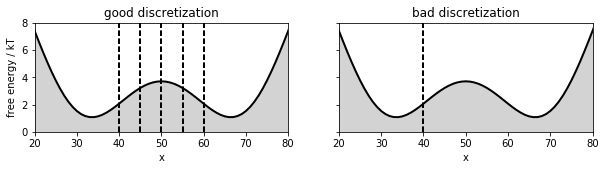

In [3]:
matplotlib.rcParams.update({'font.size': 10})
fig, axis = subplots(1, 2, figsize=(10,2))
P = double_well_data.transition_matrix
mu = msm.markov_model(P).stationary_distribution
E = -np.log(mu)
# plot 1
i = 0
axis[i].set_title('good discretization')
axis[i].plot(E-2.0, linewidth=2, color='black')
axis[i].fill_between(range(len(E)), np.zeros(len(E)), E-2.0, color='lightgrey')
axis[i].set_xlim(20,80); axis[i].set_xlabel('x'); axis[i].set_ylim(0,8); axis[i].set_ylabel('free energy / kT')
for b in [40, 45, 50, 55, 60]:
    axis[i].plot([b, b], [0, 8], linewidth=2, linestyle='dashed', color='black')
# plot 2
i = 1
axis[i].set_title('bad discretization')
axis[i].plot(E-2.0, linewidth=2, color='black')
axis[i].fill_between(range(len(E)), np.zeros(len(E)), E-2.0, color='lightgrey')
axis[i].set_xlim(20,80); axis[i].set_xlabel('x'); axis[i].set_ylim(0,8); axis[i].set_ylabel('free energy / kT')
axis[i].set_ylabel(''); axis[i].yaxis.set_ticklabels([]); 
axis[i].plot([40, 40], [0, 8], linewidth=2, linestyle='dashed', color='black')
#
#savefig('figs/fig_selval_ab.png', bbox_inches='tight')

Timescales: MSM
-----

First we want to build Markov state models. Since the discretization is given, the only parameter that still needs to be selected is the lag time. Both the discretization and the lag time are crucial for the approximation quality of a Markov state model [1,2].

One common approach to select a lagtime is to compute the relaxation timescales implied by the estimated Markov state model [3], shortly called implied timescales: 

$    t_i = -\tau / \ln | \lambda_i (\tau)| $

where $\lambda_i(\tau)$ are the eigenvalues of the Markov state model estimated at lag time $\tau$. As the relaxation timescales are physical properties of the system the implied timescales should be independent of the lag time tau. In practice, this will not be fulfilled for short lag times due to discretization errors [2]. It will neither be fulfilled for very long lag times exceeding the implied timescales as the Markov model eigenvalues are then essentially resulting from the projection on random vectors [4].

In [4]:
its_good_bmsm = msm.timescales_msm([double_well_data.dtraj_T100K_dt10_n6good], lags = 100, errors='bayes')
its_bad_bmsm = msm.timescales_msm([double_well_data.dtraj_T100K_dt10_n2bad], lags = 100, errors='bayes')

Plotting these implied timescales already show that the good discretization converges at a lag time of about 20-40 steps to a timescale somewhat about 300, while the bad discretization doesn't appear to converge. According to the variational principle of conformation dynamics [5], we know in principle that the model with longer timescales are preferable, so at this point we might select the first discretization and a lag time of 20-40 steps...

We see that the uncertainties (by default two sigma's = 95% confidence are shown) are small compared to the tau-dependent changes of the timescales in the bad discretization and we can reject that discretization even without knowing about the good discretization. The good discretization has a timescale that is indistinguishable from a constant af lag times of about 30 steps or longer.

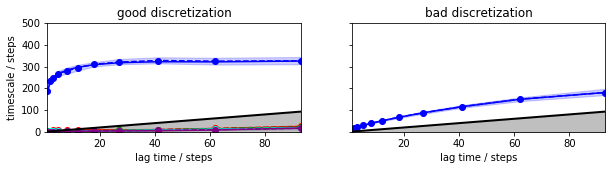

In [5]:
matplotlib.rcParams.update({'font.size': 10})
fig, axis = subplots(1, 2, figsize=(10,2))
#
mplt.plot_implied_timescales(its_good_bmsm, ax=axis[0], ylog=False)
axis[0].set_ylim(0, 500); 
axis[0].set_title('good discretization')
#
mplt.plot_implied_timescales(its_bad_bmsm, ax=axis[1], ylog=False)
axis[1].set_ylim(0, 500); axis[1].set_ylabel(''); axis[1].yaxis.set_ticklabels([]);
axis[1].set_title('bad discretization')
#
#savefig('figs/fig_selval_cd.png', bbox_inches='tight')

Hidden Markov state models
------

Now, let's play with Hidden Markov state models. Discrete Hidden Markov models (HMMs) are describe in [7]. For metastable systems such as this one, discrete HMMs can be shown to be excellent approximations to PMMs, that are exact descriptions of the non-Markovian dynamics on discretized state spaces for metastable dynamics [8]. We estimate the HMM as described in [8], which involves to first estimate a coarse-grained Markov state model and then running a HMM estimation on top of it.

1. Compute the implied timescales for the same lag times as above, but using HMSMs. Check out the documentation of the msm package.
2. Compute the implied timescales with Bayesian errors. We do this by using the algorithms described in [9]. Hint: PyEMMA implements this.
3. Estimate a Bayesian HMSM at lag time of 5 steps for both discretizations
4. Conduct a Chapman-Kolmogorov Test for both models. What do you conclude?
5. Analyze the transition matrix, the timescales and the observation probabilities of both models. Try to explain your observations
6. Adapt the lag time in the bad discretization so as to get a successful HMM model. What can be said about this model in comparison to an MSM?

In [54]:
#dtraj = double_well_data.generate_traj(5000)
#hmm = msm.estimate_hidden_markov_model(dtraj, 1, 3)
#msm.timescales_hmsm(dtraj, 1, lags=100)
its_good_bmsm_50 = msm.timescales_hmsm([double_well_data.dtraj_T100K_dt10_n6good], 2, lags = 50, errors='bayes')
its_bad_bmsm_50 = msm.timescales_hmsm([double_well_data.dtraj_T100K_dt10_n2bad], 2, lags = 50, errors='bayes')

its_good_bmsm_5 = msm.timescales_hmsm([double_well_data.dtraj_T100K_dt10_n6good], 2, lags = 5, errors='bayes')
its_bad_bmsm_5 = msm.timescales_hmsm([double_well_data.dtraj_T100K_dt10_n2bad], 2, lags = 5, errors='bayes')

#its_good_bmsm_50 = msm.timescales_hmsm([double_well_data.dtraj_T100K_dt10_n6good], 3, lags = 50, errors='bayes')
#its_bad_bmsm_50 = msm.timescales_hmsm([double_well_data.dtraj_T100K_dt10_n2bad], 3, lags = 50, errors='bayes')

#its_good_bmsm_5 = msm.timescales_hmsm([double_well_data.dtraj_T100K_dt10_n6good], 3, lags = 5, errors='bayes')
#its_bad_bmsm_5 = msm.timescales_hmsm([double_well_data.dtraj_T100K_dt10_n2bad], 3, lags = 5, errors='bayes')

/home/johnrobot/miniconda3/envs/py35/lib/python3.5/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)
/home/johnrobot/miniconda3/envs/py35/lib/python3.5/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


In [33]:
#its_good_bmsm

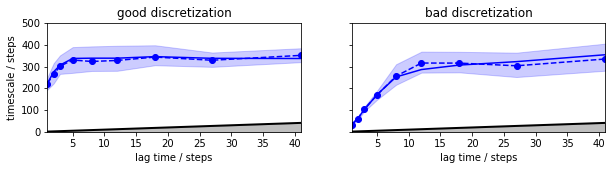

In [55]:
fig, axis = subplots(1, 2, figsize=(10,2))
#
mplt.plot_implied_timescales(its_good_bmsm_50, ax=axis[0], ylog=False)
axis[0].set_ylim(0, 500); 
axis[0].set_title('good discretization')
#
mplt.plot_implied_timescales(its_bad_bmsm_50, ax=axis[1], ylog=False)
axis[1].set_ylim(0, 500); axis[1].set_ylabel(''); axis[1].yaxis.set_ticklabels([]);
axis[1].set_title('bad discretization')



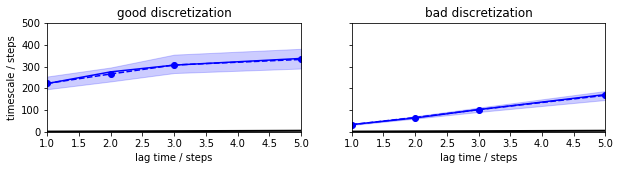

In [56]:
fig, axis = subplots(1, 2, figsize=(10,2))
#
mplt.plot_implied_timescales(its_good_bmsm_5, ax=axis[0], ylog=False)
axis[0].set_ylim(0, 500); 
axis[0].set_title('good discretization')
#
mplt.plot_implied_timescales(its_bad_bmsm_5, ax=axis[1], ylog=False)
axis[1].set_ylim(0, 500); axis[1].set_ylabel(''); axis[1].yaxis.set_ticklabels([]);
axis[1].set_title('bad discretization')

In [57]:
good_hmm=msm.bayesian_hidden_markov_model([double_well_data.dtraj_T100K_dt10_n6good],2,100)
bad_hmm=msm.bayesian_hidden_markov_model([double_well_data.dtraj_T100K_dt10_n2bad],2,100)

/home/johnrobot/miniconda3/envs/py35/lib/python3.5/site-packages/msmtools/analysis/dense/decomposition.py:540: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


In [ ]:
good_ck=good_hmm.cktest()
bad_ck=bad_hmm.cktest()

In [47]:
good_ck.

ChapmanKolmogorovValidator(conf=0.95, err_est=False, estimator=None,
              memberships=array([[ 1.,  0.],
       [ 0.,  1.]]),
              mlags=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), model=None,
              n_jobs=1, show_progress=True)

(<matplotlib.figure.Figure at 0x7fcfe604bf60>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfe5f409e8>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7fcfe5e1cdd8>]], dtype=object))

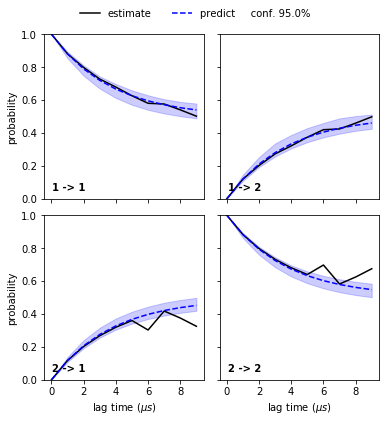

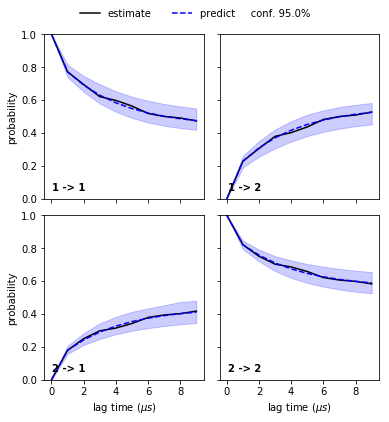

In [53]:
from pyemma import plots as peplt
peplt.plot_cktest(good_ck,dt=0.01,units=r"$\mu s$")
peplt.plot_cktest(bad_ck,dt=0.01,units=r"$\mu s$")

References
---------
[1] Prinz, J.-H., H. Wu, M. Sarich, B. G. Keller, M. Senne, M. Held, J. D. Chodera, Ch. Schütte and F. Noé: Markov models of molecular kinetics: Generation and Validation. J. Chem. Phys. 134, 174105 (2011)

[2] Sarich, M., F. Noé, Ch. Schütte: On the Approximation Quality of Markov State Models. Multiscale Model. Simul. 8, 1154-1177 (2010)

[3] Swope, W. C., J. W. Pitera and F. Suits: Describing protein folding kinetics by molecular dynamics simulations: 1. Theory, J. Phys. Chem. B. 108, 6571-6581 (2004)

[4] Beauchamp, K. A., R. McGibbon, Y. S. Lin and V. S. Pande: Simple few-state models reveal hidden complexity in protein folding. Proc. Natl. Acad. Sci. USA 109, 17807-17813 (2012)

[5] Noé, F. and F. Nüske: A variational approach to modeling slow processes in stochastic dynamical systems. SIAM Multiscale Model. Simul. 11. 635-655 (2013).

[6] Trendelkamp-Schroer, B., H. Wu, F. Paul and F. Noé: Estimation and uncertainty of reversible Markov models. arxiv.org/pdf/1507.05990 (2015)

[7] Rabiner, L. R.: A tutorial on hidden markov models and selected applications in speech recognition. Proc. IEEE 77, 257--286 (1989)

[8] Noé, F., H. Wu, J.-H. Prinz and N. Plattner, N.: Projected and Hidden Markov Models for calculating kinetics and metastable states of complex molecules. J. Chem. Phys. 139, 184114 (2013)

[9] Chodera, J. D., P. Elms, F. Noé, B. Keller, C. M. Kaiser, A. Ewall-Wice, S. Marqusee, C. Bustamante, N. Singhal Hinrichs: Bayesian hidden Markov model analysis of single-molecule force spectroscopy: Characterizing kinetics under measurement uncertainty. http://arxiv.org/abs/1108.1430.